In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [197]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [199]:
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [200]:
train = pd.read_csv('train.csv', index_col='index')
test = pd.read_csv('test.csv', index_col='index')
sample = pd.read_csv('sample_submit.csv',index_col=[0], header=None)

In [201]:
all = pd.concat([train, test])

In [202]:
train.columns

Index(['Order', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Lot Shape',
       'Land Contour', 'Lot Config', 'Neighborhood', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Exterior 1st', 'Exterior 2nd',
       'Exter Qual', 'Foundation', 'BsmtFin SF 1', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Heating QC', 'Central Air', 'Electrical',
       '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition', 'SalePrice'],
      dtype='object')

In [203]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 200 to 2732
Data columns (total 46 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order           3000 non-null   int64  
 1   MS SubClass     3000 non-null   int64  
 2   MS Zoning       3000 non-null   object 
 3   Lot Area        3000 non-null   int64  
 4   Lot Shape       3000 non-null   object 
 5   Land Contour    3000 non-null   object 
 6   Lot Config      3000 non-null   object 
 7   Neighborhood    3000 non-null   object 
 8   Bldg Type       3000 non-null   object 
 9   House Style     3000 non-null   object 
 10  Overall Qual    3000 non-null   int64  
 11  Overall Cond    3000 non-null   int64  
 12  Year Built      3000 non-null   int64  
 13  Year Remod/Add  3000 non-null   int64  
 14  Roof Style      3000 non-null   object 
 15  Exterior 1st    3000 non-null   object 
 16  Exterior 2nd    3000 non-null   object 
 17  Exter Qual      3000 non-null   obje

In [204]:
train.select_dtypes(['int64','float64']).corrwith(train['SalePrice']).sort_values(ascending=False)

SalePrice         1.000000
Full Bath         0.293996
Year Built        0.221131
Garage Cars       0.210248
Gr Liv Area       0.201057
Garage Area       0.190580
Overall Qual      0.149422
Total Bsmt SF     0.134633
Half Bath         0.130738
Year Remod/Add    0.130724
Fireplaces        0.120770
Bsmt Full Bath    0.107504
1st Flr SF        0.102831
Bsmt Unf SF       0.097631
BsmtFin SF 1      0.086038
Lot Area          0.075765
Open Porch SF     0.064211
2nd Flr SF        0.034164
Order             0.033780
Wood Deck SF      0.031295
TotRms AbvGrd     0.027719
MS SubClass       0.024983
Mo Sold           0.005314
Kitchen AbvGr    -0.017277
Yr Sold          -0.030169
Bedroom AbvGr    -0.051785
Overall Cond     -0.053452
dtype: float64

In [205]:
train.describe(include='O')

,MS Zoning,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,House Style,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,Heating QC,Central Air,Electrical,Kitchen Qual,Paved Drive,Sale Type,Sale Condition
count,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000
unique,3,2,2,3,22,5,5,2,8,8,3,4,3,2,3,3,2,2,2
top,RL,Reg,Lvl,Inside,NAmes,1Fam,1Story,Gable,VinylSd,VinylSd,TA,CBlock,Ex,Y,SBrkr,TA,Y,WD,Normal
freq,2791,2444,2983,2981,1155,2824,2051,2932,1989,1972,2285,1482,2030,2983,2981,2040,2999,2918,2931


In [206]:
train['House Style'].value_counts()

House Style
1Story    2051
2Story     691
1.5Fin     142
SLvl        84
SFoyer      32
Name: count, dtype: int64

In [207]:
np.corrcoef(train['SalePrice'], train['House Style'].astype('category').cat.codes)[0]

array([1.        , 0.06825603])

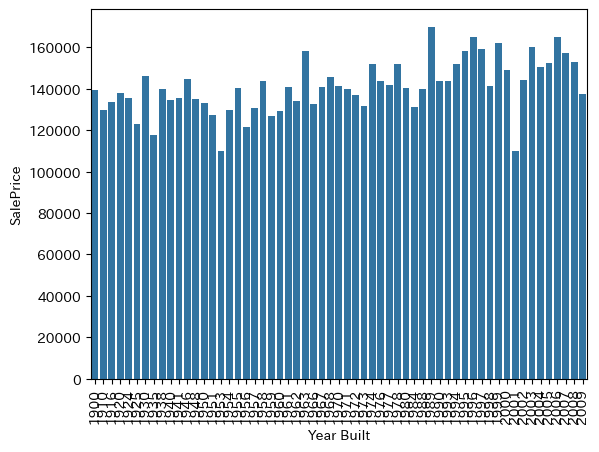

In [208]:
sns.barplot(train['SalePrice'].groupby(train['Year Built']).mean())
plt.xticks(rotation=90);

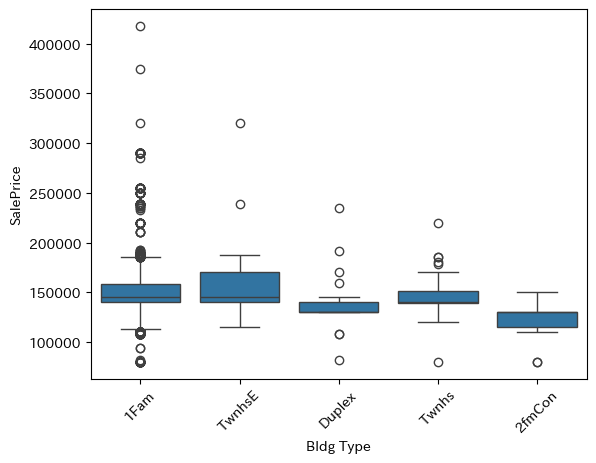

In [209]:
sns.boxplot(data = train, x='Bldg Type', y='SalePrice')
plt.xticks(rotation=45);

In [210]:
train['SalePrice'].groupby(train['Bldg Type']).mean()

Bldg Type
1Fam      150448.415722
2fmCon    121470.588235
Duplex    137653.846154
Twnhs     144527.777778
TwnhsE    156209.278351
Name: SalePrice, dtype: float64

In [211]:
# allの使用予定のカテゴリ変数変換
all['Exter Qual']=all['Exter Qual'].apply(lambda x: 1 if x=='Gd' else 0)
all['Land Contour']=all['Land Contour'].apply(lambda x: 0 if x=='Bnk' else 1)
all['Central Air']=all['Central Air'].apply(lambda x: 0 if x=='N' else 1)

In [212]:
# 外れ値のレコードを削除
all = all[~((all['House Style'] == '1Story') & (all['SalePrice'] >= 350000))]
all = all[~((all['Full Bath'] == 2) & (all['SalePrice'] >= 300000))]
all = all[~((all['Bldg Type'] == 2) & (all['SalePrice'] >= 275000))]

In [213]:
# ラベルエンコード
le = LabelEncoder()
le.fit(all['Bldg Type'])
all['Bldg Type'] = le.transform(all['Bldg Type'])

In [214]:
le.fit(all['Foundation'])
all['Foundation'] = le.transform(all['Foundation'])

In [215]:
le.fit(all['Neighborhood'])
all['Neighborhood'] = le.transform(all['Neighborhood'])

In [216]:
le.fit(all['Year Built'])
all['Year Built'] = le.transform(all['Year Built'])

In [217]:
# オブジェクトカラムをダミー変数化
all = pd.get_dummies(all)

In [218]:
all.columns

Index(['Order', 'MS SubClass', 'Lot Area', 'Land Contour', 'Neighborhood',
       'Bldg Type', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Exter Qual', 'Foundation', 'BsmtFin SF 1',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Central Air', '1st Flr SF',
       '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Mo Sold', 'Yr Sold', 'SalePrice', 'MS Zoning_FV', 'MS Zoning_RL',
       'MS Zoning_RM', 'Lot Shape_IR1', 'Lot Shape_Reg', 'Lot Config_Corner',
       'Lot Config_CulDSac', 'Lot Config_Inside', 'House Style_1.5Fin',
       'House Style_1Story', 'House Style_2Story', 'House Style_SFoyer',
       'House Style_SLvl', 'Roof Style_Gable', 'Roof Style_Hip',
       'Exterior 1st_BrkFace', 'Exterior 1st_CemntBd', 'Exterior 1st_HdBoard',
       'Exterior 1st_MetalSd', 'Exterior 1st_Plywood', 'Ext

In [219]:
# 使用カラム
use_columns = [ 'Garage Cars', 'Overall Qual', 'Year Built',  '1st Flr SF', \
                'Fireplaces','Full Bath', 'Exter Qual', 'MS Zoning_FV', 'MS Zoning_RL',\
                'MS Zoning_RM', 'Land Contour', 'Bldg Type', 'Foundation', 'Central Air', \
                'Neighborhood', 'Gr Liv Area', 'Total Bsmt SF']

In [220]:
# allをtrainとtestに分割
train = all[~all['SalePrice'].isnull()]
test = all[all['SalePrice'].isnull()]

In [221]:
train_y = train['SalePrice']
train_X = train[use_columns]
test_X = test[use_columns]

In [222]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2996 entries, 200 to 2732
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Garage Cars    2996 non-null   float64
 1   Overall Qual   2996 non-null   int64  
 2   Year Built     2996 non-null   int64  
 3   1st Flr SF     2996 non-null   int64  
 4   Fireplaces     2996 non-null   int64  
 5   Full Bath      2996 non-null   int64  
 6   Exter Qual     2996 non-null   int64  
 7   MS Zoning_FV   2996 non-null   bool   
 8   MS Zoning_RL   2996 non-null   bool   
 9   MS Zoning_RM   2996 non-null   bool   
 10  Land Contour   2996 non-null   int64  
 11  Bldg Type      2996 non-null   int32  
 12  Foundation     2996 non-null   int32  
 13  Central Air    2996 non-null   int64  
 14  Neighborhood   2996 non-null   int32  
 15  Gr Liv Area    2996 non-null   int64  
 16  Total Bsmt SF  2996 non-null   float64
dtypes: bool(3), float64(2), int32(3), int64(9)
memory usage

In [223]:
# train_X を KFoldで分割、モデル1作成、モデル1の評価
kf = KFold(n_splits=5)

scores_1 = []
for tr_idx, va_idx in kf.split(train_X):
    X_train, X_valid = train_X.iloc[tr_idx], train_X.iloc[va_idx]
    y_train, y_valid = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    model_1 = xgb.XGBRegressor(eta=0.05, n_estimators=310, max_depth=2, learning_rate=0.05,random_state=71, \
                reg_alpha = 0, reg_lambda = 1.4, min_child_weight = 1, colsample_bylevel = 0.7)
    model_1.fit(X_train, y_train)

    pred_1 = model_1.predict(X_valid)

    score_1 = MSE(y_valid, pred_1)**0.5
    scores_1.append(score_1)

print(scores_1)
print(np.mean(scores_1))


[26691.138468207075, 28405.63361423119, 23829.524007538545, 26906.9028180014, 26788.566819155178]
26524.353145426674


In [224]:
# train_X を KFoldで分割、モデル2作成、モデル2の評価
kf = KFold(n_splits=5)

scores_2 = []
for tr_idx, va_idx in kf.split(train_X):
    X_train, X_valid = train_X.iloc[tr_idx], train_X.iloc[va_idx]
    y_train, y_valid = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    model_2 = RandomForestRegressor(n_estimators=310, max_depth=5, random_state=71)
    model_2.fit(X_train, y_train)

    pred_2 = model_2.predict(X_valid)

    score_2 = MSE(y_valid, pred_2)**0.5
    scores_2.append(score_2)

print(scores_2)
print(np.mean(scores_2))


[26679.707441109214, 29282.765561397442, 23946.94962129818, 27434.04591032936, 27037.137591462648]
26876.121225119365


In [225]:
# 提出データの作成
submit = sample.copy()
test_pred = ((model_1.predict(test_X)) * 0.80) + ((model_2.predict(test_X)) * 0.20)
submit[1] = test_pred

In [226]:
submit.to_csv('submit.csv',header=None)

model1:model2 = 0.5: 0.5<br>
評価結果：26803.45982360082

model1:model2 = 0.6: 0.4<br>
評価結果：26740.29696501011

model1:model2 = 0.75: 0.25<br>
評価結果：26706.44422570366

model1:model2:model3 = 0.70: 0.15: 0.15<br>
評価結果：26690.35142545583

model1:model2:model3 = 0.70: 0.20: 0.10<br>
評価結果：26681.47431078024

model1:model2:model3 = 0.80: 0.10: 0.10<br>
評価結果：26718.3720614886

model1:model2:model3 = 0.70: 0.20: 0.10<br>
評価結果：26668.01405650614

model1:model2 = 0.80: 0.20<br>
評価結果：26689.26874676767